###### Multiple Linear Regression
## Housing Case Study


###### Step 1: Reading and Understanding the Data

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

import os

# hide warnings
import warnings
warnings.filterwarnings('ignore')


In [18]:
# reading the dataset
company = pd.read_csv("train.csv")

In [19]:
# summary of the dataset: 1460 rows, 81 columns
print(company.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [20]:
company.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Step 2: Data Cleaning

In [21]:
#Check the number of null values in the columns

company.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [22]:
# summing up the missing values (column-wise)
round(100*(company.isnull().sum()/len(company.index)), 2)

Id                0.00
MSSubClass        0.00
MSZoning          0.00
LotFrontage      17.74
LotArea           0.00
                 ...  
MoSold            0.00
YrSold            0.00
SaleType          0.00
SaleCondition     0.00
SalePrice         0.00
Length: 81, dtype: float64

In [23]:
company = company.drop('PoolQC', axis=1) ##65 % Missing
company = company.drop('Fence', axis=1) ##93 % Missing
company = company.drop('MiscFeature', axis=1) ##98 % Missing
company = company.drop('FireplaceQu', axis=1) ##34% Missing
company = company.drop('Alley', axis=1) 
company = company.drop('LotFrontage', axis=1) 

In [24]:
company = company.drop('Id', axis=1)

In [25]:
# summing up the missing values (column-wise)
round(100*(company.isnull().sum()/len(company.index)), 2)

MSSubClass       0.0
MSZoning         0.0
LotArea          0.0
Street           0.0
LotShape         0.0
                ... 
MoSold           0.0
YrSold           0.0
SaleType         0.0
SaleCondition    0.0
SalePrice        0.0
Length: 74, dtype: float64

In [26]:
company.shape

(1460, 74)

###### from 81 columns to 75 columns after removing those

In [27]:
# Dropping rows for the NaN values since we will still have sufficient data for analysis
company.dropna(axis='rows', inplace=True)

In [28]:
company.shape

(1338, 74)

In [29]:
1338/1460

0.9164383561643835

###### only 9 percent of total results are removed so we can go ahead with this approach

In [30]:
company.describe()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,...,1338.000000,1338.000000,1338.000000,1338.000000,1338.00000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,56.136024,10706.294469,6.219731,5.596413,1973.029148,1985.668909,110.360239,464.234679,49.218236,582.494768,...,99.384903,47.782511,21.263827,3.585949,16.43423,3.010463,42.932735,6.331839,2007.805680,186761.782511
std,41.252576,10336.621126,1.324472,1.078124,29.563540,20.296463,185.604816,458.792420,166.196584,439.950528,...,127.537065,65.362562,60.843964,30.224622,58.05159,41.961337,508.056255,2.699437,1.330691,78913.847668
min,20.000000,1300.000000,2.000000,2.000000,1880.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,2006.000000,35311.000000
25%,20.000000,7744.000000,5.000000,5.000000,1956.000000,1968.000000,0.000000,0.000000,0.000000,248.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,5.000000,2007.000000,135000.000000
50%,50.000000,9600.000000,6.000000,5.000000,1976.000000,1994.500000,0.000000,413.000000,0.000000,489.000000,...,6.000000,28.000000,0.000000,0.000000,0.00000,0.000000,0.000000,6.000000,2008.000000,168500.000000
75%,70.000000,11760.750000,7.000000,6.000000,2001.000000,2004.000000,174.000000,733.000000,0.000000,815.750000,...,174.500000,70.000000,0.000000,0.000000,0.00000,0.000000,0.000000,8.000000,2009.000000,220000.000000
max,190.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,...,857.000000,547.000000,552.000000,508.000000,480.00000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


###### Step 2: Visualising the Data

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:

# Creating derived features
# Converting dates (YearBuilt, YearRemodAdd, GarageYrBlt) to days (DiffYearBuilt, DiffYearRemodAdd, DiffGarageYrBlt) from today
company['DiffYearBuilt'] = pd.datetime.now().year - company['YearBuilt']
company['DiffYearRemodAdd'] = pd.datetime.now().year - company['YearRemodAdd']
company['DiffGarageYrBlt'] = pd.datetime.now().year - company['GarageYrBlt']

In [33]:
company.drop(['YearBuilt', 'YearRemodAdd', 'GarageYrBlt'], axis=1, inplace=True)

In [34]:
company.columns

Index(['MSSubClass', 'MSZoning', 'LotArea', 'Street', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 

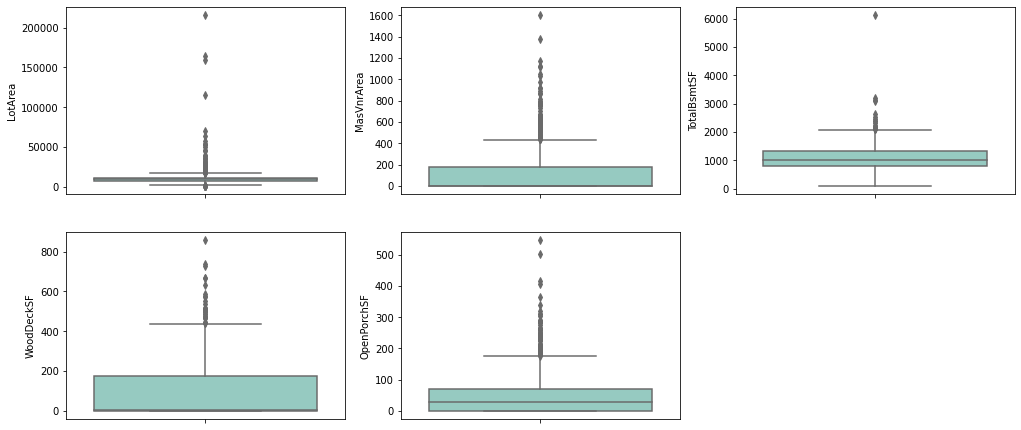

In [35]:
# Check the outliers in all the numeric columns

plt.figure(figsize=(17, 20))
plt.subplot(5,3,1)
sns.boxplot(y = 'LotArea', palette='Set3', data = company)
plt.subplot(5,3,2)
sns.boxplot(y = 'MasVnrArea', palette='Set3', data = company)
plt.subplot(5,3,3)
sns.boxplot(y = 'TotalBsmtSF', palette='Set3', data = company)
plt.subplot(5,3,4)
sns.boxplot(y = 'WoodDeckSF', palette='Set3', data = company)
plt.subplot(5,3,5)
sns.boxplot(y = 'OpenPorchSF', palette='Set3', data = company)
plt.show()

In [36]:
# Removing Outliers

# Removing values beyond 98% for LotArea

nn_quartile_LotArea = company['LotArea'].quantile(0.98)
company = company[company["LotArea"] < nn_quartile_LotArea]

# Removing values beyond 98% for MasVnrArea

nn_quartile_MasVnrArea = company['MasVnrArea'].quantile(0.98)
company = company[company["MasVnrArea"] < nn_quartile_MasVnrArea]

# Removing values beyond 99% for TotalBsmtSF

nn_quartile_TotalBsmtSF = company['TotalBsmtSF'].quantile(0.99)
company = company[company["TotalBsmtSF"] < nn_quartile_TotalBsmtSF]

# Removing values beyond 99% for WoodDeckSF

nn_quartile_WoodDeckSF = company['WoodDeckSF'].quantile(0.99)
company = company[company["WoodDeckSF"] < nn_quartile_WoodDeckSF]

# Removing values beyond 99% for OpenPorchSF

nn_quartile_OpenPorchSF = company['OpenPorchSF'].quantile(0.99)
company = company[company["OpenPorchSF"] < nn_quartile_OpenPorchSF]

In [37]:
company.head()

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,DiffYearBuilt,DiffYearRemodAdd,DiffGarageYrBlt
0,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,2,2008,WD,Normal,208500,18,18,18.0
1,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,0,0,5,2007,WD,Normal,181500,45,45,45.0
2,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,9,2008,WD,Normal,223500,20,19,20.0
3,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,0,0,2,2006,WD,Abnorml,140000,106,51,23.0
4,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,0,0,12,2008,WD,Normal,250000,21,21,21.0


In [38]:
##Drop the following columns that have more than 85% values associated to a specific value

# Method to get the column names that have count of one value more than 85%

def getHighCategoricalValueCounts():
    column = []
    categorical_columns = company.select_dtypes(include=['object'])
    for col in (categorical_columns):
        if(company[col].value_counts().max() >= 1241):
            column.append(col)
    return column

columnsToBeRemoved = getHighCategoricalValueCounts()

# Remove the columns with skewed data

company.drop(columnsToBeRemoved, axis = 1, inplace = True)

company.head()

,MSSubClass,MSZoning,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,DiffYearBuilt,DiffYearRemodAdd,DiffGarageYrBlt
0,60,RL,8450,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,...,0,0,2,2008,WD,Normal,208500,18,18,18.0
1,20,RL,9600,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,...,0,0,5,2007,WD,Normal,181500,45,45,45.0
2,60,RL,11250,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,...,0,0,9,2008,WD,Normal,223500,20,19,20.0
3,70,RL,9550,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,...,0,0,2,2006,WD,Abnorml,140000,106,51,23.0
4,60,RL,14260,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,...,0,0,12,2008,WD,Normal,250000,21,21,21.0


In [39]:
# Separating numerical and categorical fields for analysisng them separately using the provided Data Dictionary.

# OUTCOME COLUMN:
out_col = 'SalePrice'

# NUMERICAL COLUMNS: 
num_col = ['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 
           'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
           'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 
           'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'DiffYearBuilt', 'DiffYearRemodAdd',
           'DiffGarageYrBlt']
print(len(num_col))

# CATEGORICAL COLUMNS: 
cat_col = ['MSSubClass', 'MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope',
           'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
           'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 
           'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
           'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 
           'GarageQual', 'GarageCond', 'PavedDrive', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']
print(len(cat_col))


30
41


### Step 4 Data Preperation

In [40]:
company.head()

,MSSubClass,MSZoning,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,DiffYearBuilt,DiffYearRemodAdd,DiffGarageYrBlt
0,60,RL,8450,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,...,0,0,2,2008,WD,Normal,208500,18,18,18.0
1,20,RL,9600,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,...,0,0,5,2007,WD,Normal,181500,45,45,45.0
2,60,RL,11250,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,...,0,0,9,2008,WD,Normal,223500,20,19,20.0
3,70,RL,9550,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,...,0,0,2,2006,WD,Abnorml,140000,106,51,23.0
4,60,RL,14260,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,...,0,0,12,2008,WD,Normal,250000,21,21,21.0


In [41]:
# Creating the dummy variables for the variables month,season,weathersit,weekday and storing them 
# in new variable 'months',seasons','weather' and 'weekdays' respectively and 
# dropping the first column from these variables using 'drop_first = True'
# For the following columns create dummies

# Creating dummies for MSZoning

#d_MSZoning = pd.get_dummies(company['MSZoning'], prefix='MSZoning', drop_first = True)
#company = pd.concat([company, d_MSZoning], axis = 1)

# Creating dummies for Neighborhood

d_Neighborhood = pd.get_dummies(company['Neighborhood'], prefix='Neighborhood', drop_first = True)
company = pd.concat([company, d_Neighborhood], axis = 1)

# Creating dummies for RoofStyle

d_RoofStyle = pd.get_dummies(company['RoofStyle'], prefix='RoofStyle', drop_first = True)
company = pd.concat([company, d_RoofStyle], axis = 1)

# Creating dummies for Exterior1st

d_Exterior1st = pd.get_dummies(company['Exterior1st'], prefix='Exterior1st', drop_first = True)
company = pd.concat([company, d_Exterior1st], axis = 1)

# Creating dummies for Exterior2nd

d_Exterior2nd = pd.get_dummies(company['Exterior2nd'], prefix='Exterior2nd', drop_first = True)
company = pd.concat([company, d_Exterior2nd], axis = 1)

# Creating dummies for Foundation

d_Foundation = pd.get_dummies(company['Foundation'], prefix='Foundation', drop_first = True)
company = pd.concat([company, d_Foundation], axis = 1)

# Creating dummies for GarageType


d_RoofMatl = pd.get_dummies(company['RoofMatl'], prefix='RoofMatl', drop_first = True)
company = pd.concat([company, d_RoofMatl], axis = 1)


d_Condition1= pd.get_dummies(company['Condition1'], prefix='Condition1', drop_first = True)
company = pd.concat([company, d_Condition1], axis = 1)

d_Condition2= pd.get_dummies(company['Condition2'], prefix='Condition2', drop_first = True)
company = pd.concat([company, d_Condition2], axis = 1)

d_LandContour= pd.get_dummies(company['LandContour'], prefix='LandContour', drop_first = True)
company = pd.concat([company, d_LandContour], axis = 1)

d_LandSlope= pd.get_dummies(company['LandSlope'], prefix='LandSlope', drop_first = True)
company = pd.concat([company, d_LandSlope], axis = 1)

############3
d_Functional= pd.get_dummies(company['Functional'], prefix='Functional', drop_first = True)
company = pd.concat([company, d_Functional], axis = 1)

d_Heating= pd.get_dummies(company['Heating'], prefix='Heating', drop_first = True)
company = pd.concat([company, d_Heating], axis = 1)

d_CentralAir= pd.get_dummies(company['CentralAir'], prefix='CentralAir', drop_first = True)
company = pd.concat([company, d_CentralAir], axis = 1)

d_Electrical= pd.get_dummies(company['Electrical'], prefix='Electrical', drop_first = True)
company = pd.concat([company, d_Electrical], axis = 1)

d_SaleType= pd.get_dummies(company['SaleType'], prefix='SaleType', drop_first = True)
company = pd.concat([company, d_SaleType], axis = 1)

d_PavedDrive= pd.get_dummies(company['PavedDrive'], prefix='PavedDrive', drop_first = True)
company = pd.concat([company, d_PavedDrive], axis = 1)

 

company.head()

,MSSubClass,MSZoning,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,PavedDrive_P,PavedDrive_Y
0,60,RL,8450,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,...,0,0,0,0,0,0,0,1,0,1
1,20,RL,9600,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,...,0,0,0,0,0,0,0,1,0,1
2,60,RL,11250,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,...,0,0,0,0,0,0,0,1,0,1
3,70,RL,9550,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,...,0,0,0,0,0,0,0,1,0,1
4,60,RL,14260,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,...,0,0,0,0,0,0,0,1,0,1


In [42]:
company.columns

Index(['MSSubClass', 'MSZoning', 'LotArea', 'LotShape', 'LandContour',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       ...
       'SaleType_CWD', 'SaleType_Con', 'SaleType_ConLD', 'SaleType_ConLI',
       'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD',
       'PavedDrive_P', 'PavedDrive_Y'],
      dtype='object', length=180)

In [43]:

# drop the below columns as we now have new columns derived from these columns

company = company.drop(['MSZoning', 'Neighborhood', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'Foundation', 
                               'GarageType', 'RoofMatl', 'Condition1', 'Condition2','LandContour', 'LandSlope','Functional','Heating','CentralAir','Electrical','SaleType','PavedDrive'], axis=1)



In [44]:

#company = company.drop(['RoofMatl', 'Condition1', 'Condition2','LandContour', 'LandSlope' ])
#company.head()

In [45]:

# Since the values of the following fields are ordered list, we shall assign values to them in sequence

# For values which can be ordered, we have given an ordered sequence value
# For values which cannot be ordered, we have categorised them into 0 and 1

company['d_LotShape'] = company['LotShape'].map({'Reg': 3, 'IR1': 2, 'IR2': 1, 'IR3': 0})
company['d_ExterQual'] = company['ExterQual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0 })
company['d_BsmtQual'] = company['BsmtQual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})
company['d_BsmtExposure'] = company['BsmtExposure'].map({'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0})
company['d_BsmtFinType1'] = company['BsmtFinType1'].map({'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 
                                                                 'None': 0})
company['d_HeatingQC'] = company['HeatingQC'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})
company['d_KitchenQual'] = company['KitchenQual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})
company['d_GarageFinish'] = company['GarageFinish'].map({'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0 })
company['d_BldgType'] = company['BldgType'].map({'Twnhs': 5, 'TwnhsE': 4, 'Duplex': 3, '2fmCon': 2, '1Fam': 1, 
                                                                 'None': 0 })
company['d_HouseStyle'] = company['HouseStyle'].map({'SLvl': 8, 'SFoyer': 7, '2.5Fin': 6, '2.5Unf': 5, '2Story': 4, 
                                                                 '1.5Fin': 3, '1.5Unf': 2, '1Story': 1, 'None': 0 })
company['d_LotConfig'] = company['LotConfig'].map({'Inside': 5, 'Corner': 4, 'CulDSac': 3, 'FR2': 2, 'FR3': 1, 
                                                           'None': 0  })
company['d_MasVnrType'] = company['MasVnrType'].map({'BrkCmn': 1, 'BrkFace': 1, 'CBlock': 1, 'Stone': 1, 'None': 0 })
company['d_SaleCondition'] = company['SaleCondition'].map({'Normal': 1, 'Partial': 1, 'Abnorml': 0, 'Family': 0, 
                                                                   'Alloca': 0, 'AdjLand': 0, 'None': 0})



company['d_BsmtFinType2'] = company['BsmtFinType2'].map({'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0})
company['d_ExterCond'] = company['ExterCond'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0 })                                                            
company['d_BsmtCond'] = company['BsmtCond'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0 })

company['d_GarageQual'] = company['GarageQual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0 })

company['d_GarageCond'] = company['GarageCond'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0 })


company.head()

,MSSubClass,LotArea,LotShape,LotConfig,BldgType,HouseStyle,OverallQual,OverallCond,MasVnrType,MasVnrArea,...,d_BldgType,d_HouseStyle,d_LotConfig,d_MasVnrType,d_SaleCondition,d_BsmtFinType2,d_ExterCond,d_BsmtCond,d_GarageQual,d_GarageCond
0,60,8450,Reg,Inside,1Fam,2Story,7,5,BrkFace,196.0,...,1,4,5,1,1,1,3,3,3,3
1,20,9600,Reg,FR2,1Fam,1Story,6,8,None,0.0,...,1,1,2,0,1,1,3,3,3,3
2,60,11250,IR1,Inside,1Fam,2Story,7,5,BrkFace,162.0,...,1,4,5,1,1,1,3,3,3,3
3,70,9550,IR1,Corner,1Fam,2Story,7,5,None,0.0,...,1,4,4,0,0,1,3,4,3,3
4,60,14260,IR1,FR2,1Fam,2Story,8,5,BrkFace,350.0,...,1,4,2,1,1,1,3,3,3,3


In [46]:
columnsToBeRemoved

['Street', 'Utilities']

In [48]:
# drop the old columns from which the new columns were derived
# We can also drop the id column as it will not be used any more

company = company.drop(['LotShape', 'ExterQual', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'HeatingQC', 
                                'KitchenQual', 'GarageFinish', 'BldgType', 'HouseStyle', 
                                'LotConfig', 'MasVnrType', 'SaleCondition','BsmtFinType2','ExterCond','BsmtCond','GarageQual','GarageCond','OverallQual','OverallCond', 'GrLivArea'], axis=1)



company.head()




,MSSubClass,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,d_BldgType,d_HouseStyle,d_LotConfig,d_MasVnrType,d_SaleCondition,d_BsmtFinType2,d_ExterCond,d_BsmtCond,d_GarageQual,d_GarageCond
0,60,8450,196.0,706,0,150,856,856,854,0,...,1,4,5,1,1,1,3,3,3,3
1,20,9600,0.0,978,0,284,1262,1262,0,0,...,1,1,2,0,1,1,3,3,3,3
2,60,11250,162.0,486,0,434,920,920,866,0,...,1,4,5,1,1,1,3,3,3,3
3,70,9550,0.0,216,0,540,756,961,756,0,...,1,4,4,0,0,1,3,4,3,3
4,60,14260,350.0,655,0,490,1145,1145,1053,0,...,1,4,2,1,1,1,3,3,3,3


In [49]:
company = company

In [50]:
#company.dtypes[company.dtypes = 'object']

###### Modeling

In [51]:
# Putting all feature variable to X

X = company.drop(['SalePrice'], axis=1)
X.head()

,MSSubClass,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,d_BldgType,d_HouseStyle,d_LotConfig,d_MasVnrType,d_SaleCondition,d_BsmtFinType2,d_ExterCond,d_BsmtCond,d_GarageQual,d_GarageCond
0,60,8450,196.0,706,0,150,856,856,854,0,...,1,4,5,1,1,1,3,3,3,3
1,20,9600,0.0,978,0,284,1262,1262,0,0,...,1,1,2,0,1,1,3,3,3,3
2,60,11250,162.0,486,0,434,920,920,866,0,...,1,4,5,1,1,1,3,3,3,3
3,70,9550,0.0,216,0,540,756,961,756,0,...,1,4,4,0,0,1,3,4,3,3
4,60,14260,350.0,655,0,490,1145,1145,1053,0,...,1,4,2,1,1,1,3,3,3,3


In [52]:
X.dtypes

MSSubClass          int64
LotArea             int64
MasVnrArea        float64
BsmtFinSF1          int64
BsmtFinSF2          int64
                   ...   
d_BsmtFinType2      int64
d_ExterCond         int64
d_BsmtCond          int64
d_GarageQual        int64
d_GarageCond        int64
Length: 158, dtype: object

In [53]:
# Putting response variable to y

y = company['SalePrice']
y.head()

0    208500
1    181500
2    223500
3    140000
4    250000
Name: SalePrice, dtype: int64

In [54]:
# scaling the features

from sklearn.preprocessing import scale

# storing column names in cols
# scaling (the dataframe is converted to a numpy array)

cols = X.columns
X = pd.DataFrame(scale(X))
X.columns = cols
X.columns

Index(['MSSubClass', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       ...
       'd_BldgType', 'd_HouseStyle', 'd_LotConfig', 'd_MasVnrType',
       'd_SaleCondition', 'd_BsmtFinType2', 'd_ExterCond', 'd_BsmtCond',
       'd_GarageQual', 'd_GarageCond'],
      dtype='object', length=158)

### Step 7 Test Train Split

In [55]:
# split into train and test


from sklearn.model_selection import train_test_split

np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size = 0.3, random_state=42)

## RFE

###### We have 174 features lets try first 50 in first iteration

In [56]:
company.shape

(1245, 159)

In [57]:
# Running RFE with the output number of the variable equal to 50
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(X_train, y_train)

# running RFE
rfe = RFE(lm, 50)            
rfe = rfe.fit(X_train, y_train)

In [58]:
X_train.columns

Index(['MSSubClass', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       ...
       'd_BldgType', 'd_HouseStyle', 'd_LotConfig', 'd_MasVnrType',
       'd_SaleCondition', 'd_BsmtFinType2', 'd_ExterCond', 'd_BsmtCond',
       'd_GarageQual', 'd_GarageCond'],
      dtype='object', length=158)

In [59]:
# Assign the columns selected by RFE to cols

col = X_train.columns[rfe.support_]

# assign the 50 features selected using RFE to a dataframe and view them

temp_df = pd.DataFrame(list(zip(X_train.columns,rfe.support_,rfe.ranking_)), columns=['Variable', 'rfe_support', 'rfe_ranking'])
temp_df = temp_df.loc[temp_df['rfe_support'] == True]
temp_df.reset_index(drop=True, inplace=True)

temp_df 

,Variable,rfe_support,rfe_ranking
0,BsmtFinSF1,True,1
1,BsmtFinSF2,True,1
2,BsmtUnfSF,True,1
3,TotalBsmtSF,True,1
4,1stFlrSF,True,1
5,2ndFlrSF,True,1
6,BedroomAbvGr,True,1
7,KitchenAbvGr,True,1
8,TotRmsAbvGrd,True,1
9,Fireplaces,True,1


In [60]:
# Assign the 50 columns to X_train_rfe

X_train_rfe = X_train[col]
# Associate the new 50 columns to X_train and X_test for further analysis

X_train = X_train_rfe[X_train_rfe.columns]
X_test =  X_test[X_train.columns]

In [61]:
X.dtypes

MSSubClass        float64
LotArea           float64
MasVnrArea        float64
BsmtFinSF1        float64
BsmtFinSF2        float64
                   ...   
d_BsmtFinType2    float64
d_ExterCond       float64
d_BsmtCond        float64
d_GarageQual      float64
d_GarageCond      float64
Length: 158, dtype: object

In [62]:
X_test.dtypes

BsmtFinSF1              float64
BsmtFinSF2              float64
BsmtUnfSF               float64
TotalBsmtSF             float64
1stFlrSF                float64
2ndFlrSF                float64
BedroomAbvGr            float64
KitchenAbvGr            float64
TotRmsAbvGrd            float64
Fireplaces              float64
GarageArea              float64
MiscVal                 float64
DiffYearBuilt           float64
DiffYearRemodAdd        float64
Neighborhood_BrDale     float64
Neighborhood_CollgCr    float64
Neighborhood_Crawfor    float64
Neighborhood_Gilbert    float64
Neighborhood_NPkVill    float64
Neighborhood_NridgHt    float64
Neighborhood_StoneBr    float64
RoofStyle_Shed          float64
Exterior1st_BrkFace     float64
Exterior1st_CemntBd     float64
Exterior1st_HdBoard     float64
Exterior1st_MetalSd     float64
Exterior1st_Plywood     float64
Exterior1st_Stucco      float64
Exterior1st_VinylSd     float64
Exterior1st_WdShing     float64
Exterior2nd_CmentBd     float64
Exterior

### Step 8 - Model Building and evaluation

In [63]:
# list pf alphas

params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 
                    9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation

folds = 5
ridge_model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
ridge_model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5,
                                   0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0,
                                   6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500,
                                   1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [64]:
# display the mean scores

ridge_cv_results = pd.DataFrame(ridge_model_cv.cv_results_)
ridge_cv_results = ridge_cv_results[ridge_cv_results['param_alpha']<=500]
ridge_cv_results[['param_alpha', 'mean_train_score', 'mean_test_score', 'rank_test_score']].sort_values(by = ['rank_test_score'])

,param_alpha,mean_train_score,mean_test_score,rank_test_score
22,20,-15813.948696,-16845.547000,1
21,10,-15767.869825,-16874.516745,2
20,9,-15765.571104,-16880.913681,3
19,8,-15763.687997,-16888.212690,4
18,7,-15762.110886,-16896.354635,5
17,6,-15760.797010,-16905.329164,6
16,5,-15759.891126,-16915.446431,7
23,50,-15995.878735,-16924.712566,8
15,4,-15759.831695,-16927.464617,9
14,3,-15760.026851,-16942.632061,10


In [65]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None
X_test.columns

Index(['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageArea', 'MiscVal', 'DiffYearBuilt',
       'DiffYearRemodAdd', 'Neighborhood_BrDale', 'Neighborhood_CollgCr',
       'Neighborhood_Crawfor', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill',
       'Neighborhood_NridgHt', 'Neighborhood_StoneBr', 'RoofStyle_Shed',
       'Exterior1st_BrkFace', 'Exterior1st_CemntBd', 'Exterior1st_HdBoard',
       'Exterior1st_MetalSd', 'Exterior1st_Plywood', 'Exterior1st_Stucco',
       'Exterior1st_VinylSd', 'Exterior1st_WdShing', 'Exterior2nd_CmentBd',
       'Exterior2nd_HdBoard', 'Exterior2nd_ImStucc', 'Exterior2nd_MetalSd',
       'Exterior2nd_Other', 'Exterior2nd_Plywood', 'Exterior2nd_Stone',
       'Exterior2nd_Stucco', 'Exterior2nd_VinylSd', 'Exterior2nd_Wd Sdng',
       'Exterior2nd_Wd Shng', 'Condition2_RRAe', 'Functional_Typ',
       'SaleType_New', 'd_ExterQual', 'd_BsmtQual', 

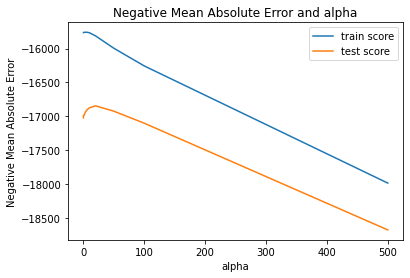

In [66]:
# plotting mean test and train scoes with alpha 

ridge_cv_results['param_alpha'] = ridge_cv_results['param_alpha'].astype('int32')

# plotting

plt.plot(ridge_cv_results['param_alpha'], ridge_cv_results['mean_train_score'])
plt.plot(ridge_cv_results['param_alpha'], ridge_cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()


In [67]:

# get the best estimator for lambda

ridge_model_cv.best_estimator_

Ridge(alpha=20)

In [92]:

# check the coefficient values with lambda = 20

alpha = 20
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
ridge.coef_

array([ 7064.57958216,  -215.2016391 ,  -319.58633594,  8046.98693388,
       16877.15772097, 22099.60937018, -2847.55649672, -4592.79067784,
        4899.62537457,  3972.62177373,  7647.88746896,  2554.43184417,
       -7538.41001154, -4659.77919667,  2756.49996072, -2923.069346  ,
        6941.02237243, -2144.49857937,  2721.72570134,  5716.16247421,
        5636.76973412,  -785.07198791,  3570.03964947,  -700.78959268,
        1834.19236464,  2765.41946206,  -842.55323654,  2572.47837655,
        1565.05481156,   701.91824515,  3643.68879109,   166.42377924,
        1002.00194315,  1435.30750001,  -716.40795804,   423.07598983,
        -446.68009424,   201.80338132,  1940.73530676,  2597.10980175,
          80.49156287, -1109.81311726,  4420.62917631,  5288.8837917 ,
        6383.79561478,  5997.31135377,  4526.363897  ,  2632.34365901,
        4183.85731018, -9446.40747769])

In [93]:
# Check the mean squared error

mean_squared_error(y_test, ridge.predict(X_test))

630899144.8266295

In [94]:
y_test

860     189950
513     134000
1310    335000
389     426000
381     187750
1418    124000
1201    197900
92      163500
45      319900
1108    181000
1100     60000
557     108000
1212    113000
1135    102000
574     139000
245     241500
1227    147000
346     151500
288     122000
1116    184100
231     403000
1236    175500
1386    250000
541     248000
1457    266500
721     143000
255     230000
966     160000
1414    207000
424     139000
544     179665
943     143000
272     290000
199     274900
754     156000
341      82000
490     115000
611     148000
680     143000
337     214000
488     160000
315     188500
437     119000
604     221000
1198    178000
1440    191000
1327    130500
500     113000
1067    167900
493     155000
700     312500
1301    177500
1147    174500
52      110000
665     230500
347     157500
1101    119500
345     140200
506     215000
420     206300
872     116000
86      174000
69      225000
1319    111000
1314    119000
459     110000
599     15

In [95]:
X_test

,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageArea,MiscVal,DiffYearBuilt,DiffYearRemodAdd,Neighborhood_BrDale,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Gilbert,Neighborhood_NPkVill,Neighborhood_NridgHt,Neighborhood_StoneBr,RoofStyle_Shed,Exterior1st_BrkFace,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_WdShing,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Condition2_RRAe,Functional_Typ,SaleType_New,d_ExterQual,d_BsmtQual,d_BsmtExposure,d_HeatingQC,d_KitchenQual,d_BldgType
735,-1.061064,-0.293642,0.791415,-0.430747,-0.673014,0.403006,0.197255,-0.175249,0.359358,0.613851,-1.554041,-0.082991,1.843175,-0.615665,-0.110432,-0.363068,4.888763,-0.254976,-0.085332,-0.225018,-0.130984,-0.040112,-0.177435,-0.189139,-0.438781,-0.427008,-0.277470,-0.124489,-0.765498,-0.124489,-0.189139,-0.419091,-0.080419,-0.421737,-0.028352,-0.315948,-0.040112,-0.130984,-0.751046,2.594787,-0.157135,-0.028352,0.253185,-0.298729,1.097062,-0.847524,-0.628709,-0.191263,0.746005,-0.402941
442,-0.243874,-0.293642,0.406654,0.075547,-0.178591,-0.811318,0.197255,-0.175249,-0.954594,-0.975015,-0.028462,-0.082991,-0.352340,0.117644,-0.110432,-0.363068,-0.204551,-0.254976,-0.085332,-0.225018,-0.130984,-0.040112,-0.177435,-0.189139,-0.438781,-0.427008,-0.277470,-0.124489,1.306339,-0.124489,-0.189139,-0.419091,-0.080419,-0.421737,-0.028352,-0.315948,-0.040112,-0.130984,1.331476,-0.385388,-0.157135,-0.028352,0.253185,-0.298729,-0.726492,-0.847524,-0.628709,-1.254313,-0.828192,-0.402941
1117,2.358488,-0.293642,-0.184564,2.483385,2.240547,-0.811318,0.197255,-0.175249,0.359358,2.202717,0.444012,-0.082991,0.458311,-0.811214,-0.110432,-0.363068,4.888763,-0.254976,-0.085332,-0.225018,-0.130984,-0.040112,5.635881,-0.189139,-0.438781,-0.427008,-0.277470,-0.124489,-0.765498,-0.124489,-0.189139,2.386116,-0.080419,-0.421737,-0.028352,-0.315948,-0.040112,-0.130984,-0.751046,-0.385388,-0.157135,-0.028352,0.253185,-0.298729,1.097062,0.649167,1.355431,-1.254313,2.320202,-0.402941
333,2.052042,-0.293642,-0.405098,1.835800,1.769669,0.582556,0.197255,-0.175249,1.673309,0.613851,2.032207,-0.082991,-1.162992,-1.104538,-0.110432,-0.363068,-0.204551,-0.254976,-0.085332,4.444097,-0.130984,-0.040112,-0.177435,-0.189139,-0.438781,-0.427008,-0.277470,-0.124489,1.306339,-0.124489,-0.189139,-0.419091,-0.080419,-0.421737,-0.028352,-0.315948,-0.040112,-0.130984,1.331476,-0.385388,-0.157135,-0.028352,0.253185,3.347519,2.920616,2.145857,1.355431,0.871786,2.320202,-0.402941
327,-1.061064,-0.293642,1.685280,0.690752,0.471810,-0.811318,-1.109033,-0.175249,-0.954594,0.613851,0.472474,-0.082991,-1.129215,-1.006763,-0.110432,-0.363068,-0.204551,-0.254976,-0.085332,-0.225018,-0.130984,-0.040112,-0.177435,-0.189139,-0.438781,-0.427008,-0.277470,-0.124489,1.306339,-0.124489,-0.189139,-0.419091,-0.080419,-0.421737,-0.028352,-0.315948,-0.040112,-0.130984,1.331476,-0.385388,-0.157135,-0.028352,0.253185,3.347519,1.097062,0.649167,-0.628709,0.871786,0.746005,-0.402941
1209,-1.000261,5.109025,-0.768744,0.252161,0.009760,-0.811318,0.197255,-0.175249,-0.297618,-0.975015,-0.870946,-0.082991,0.323203,1.095389,-0.110432,-0.363068,-0.204551,-0.254976,-0.085332,-0.225018,-0.130984,-0.040112,-0.177435,-0.189139,2.279041,-0.427008,-0.277470,-0.124489,-0.765498,-0.124489,-0.189139,2.386116,-0.080419,-0.421737,-0.028352,-0.315948,-0.040112,-0.130984,-0.751046,-0.385388,-0.157135,-0.028352,0.253185,-0.298729,-0.726492,-0.847524,-0.628709,-1.254313,-0.828192,-0.402941
1026,-1.061064,-0.293642,0.683494,-0.566151,-0.808391,1.345644,0.197255,-0.175249,-0.297618,-0.975015,0.324470,-0.082991,-0.858998,-0.615665,-0.110432,2.754307,-0.204551,-0.254976,-0.085332,-0.225018,-0.130984,-0.040112,-0.177435,-

In [72]:
ridge.predict(X_test)

array([183920.90272642, 130616.50356388, 322346.48289268, 386657.73021741,
       217405.65395387, 114380.78698351, 190812.13866294, 168133.9725061 ,
       274133.55129389, 178757.50475103,  40642.60387119, 133394.75723952,
        76831.56649036,  92299.7978559 , 120090.34341124, 236421.50452474,
       143990.81778714, 202216.94764188, 106868.48010293, 181510.81306449,
       309127.06142526, 183648.10424308, 278726.98641484, 245468.32629567,
       294638.74583276, 134262.40676974, 226924.84748854, 169050.77824022,
       164721.72554311, 148281.99031468, 220868.17545996, 131743.0115857 ,
       263414.73637897, 313305.8253306 , 128009.66686908,  64576.20869911,
       107949.94316021, 161023.77442858,  95390.42738385, 222723.1905169 ,
       148722.66600126, 184543.20126583, 103693.71144535, 219969.7514015 ,
       173548.92835942, 226397.45138133, 142824.530249  , 110197.85738823,
       161445.51403553, 156600.56885375, 289018.32756094, 178569.68695518,
       169034.41035649,  

In [96]:

# Put the Features and coefficienst in a dataframe

ridge_df = pd.DataFrame({'Features':X_train.columns, 'Coefficient':ridge.coef_.round(4)})
ridge_df.reset_index(drop=True, inplace=True)
ridge_df

,Features,Coefficient
0,BsmtFinSF1,7064.5796
1,BsmtFinSF2,-215.2016
2,BsmtUnfSF,-319.5863
3,TotalBsmtSF,8046.9869
4,1stFlrSF,16877.1577
5,2ndFlrSF,22099.6094
6,BedroomAbvGr,-2847.5565
7,KitchenAbvGr,-4592.7907
8,TotRmsAbvGrd,4899.6254
9,Fireplaces,3972.6218


In [97]:

# Do an RFE to minimise the features to 20
X_train_ridge = X_train[ridge_df.Features]

lm = LinearRegression()
lm.fit(X_train_ridge, y_train)

# running RFE
rfe = RFE(lm, 20)            
rfe = rfe.fit(X_train_ridge, y_train)

In [75]:
# Assign the Features and their coefficient values to a dictionary which would be used while plotting the bar plot

ridge_coeff_dict = dict(pd.Series(ridge.coef_.round(4), index = X_train.columns))
ridge_coeff_dict



# Method to get the coefficient values

def find(x):
    return ridge_coeff_dict[x]

# Assign top 20 features to a temp dataframe for further display in the bar plot

temp1_df = pd.DataFrame(list(zip( X_train_ridge.columns, rfe.support_, rfe.ranking_)), columns=['Features', 'rfe_support', 'rfe_ranking'])
temp1_df = temp1_df.loc[temp1_df['rfe_support'] == True]
temp1_df.reset_index(drop=True, inplace=True)

temp1_df['Coefficient'] = temp1_df['Features'].apply(find)
temp1_df = temp1_df.sort_values(by=['Coefficient'], ascending=False)
temp1_df = temp1_df.head(10)
temp1_df

,Features,rfe_support,rfe_ranking,Coefficient
5,2ndFlrSF,True,1,22099.6094
4,1stFlrSF,True,1,16877.1577
3,TotalBsmtSF,True,1,8046.9869
9,GarageArea,True,1,7647.8875
0,BsmtFinSF1,True,1,7064.5796
11,Neighborhood_Crawfor,True,1,6941.0224
16,d_ExterQual,True,1,6383.7956
17,d_BsmtQual,True,1,5997.3114
12,Neighborhood_NridgHt,True,1,5716.1625
13,Neighborhood_StoneBr,True,1,5636.7697


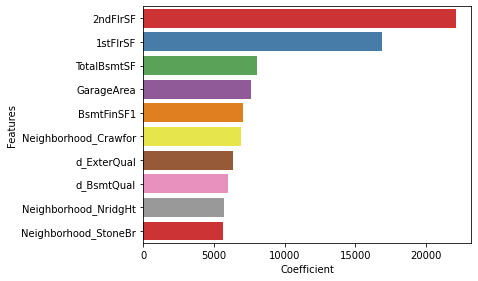

In [98]:
# bar plot to determine the variables that would affect pricing most using ridge regression

plt.figure(figsize=(20,20))
plt.subplot(4,3,1)
sns.barplot(y = 'Features', x='Coefficient', palette='Set1', data = temp1_df)
plt.show()

###### Lasso

In [99]:

lasso = Lasso()

# list of alphas

params = {'alpha': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01]}

# cross validation

folds = 5
lasso_model_cv = GridSearchCV(estimator = lasso,                         
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

lasso_model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005,
                                   0.001, 0.002, 0.003, 0.004, 0.005, 0.01]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [100]:
# display the mean scores

lasso_cv_results = pd.DataFrame(lasso_model_cv.cv_results_)
lasso_cv_results[['param_alpha', 'mean_train_score', 'mean_test_score', 'rank_test_score']].sort_values(by = ['rank_test_score'])

,param_alpha,mean_train_score,mean_test_score,rank_test_score
10,0.01,-15764.299780,-17022.512423,1
9,0.005,-15764.302454,-17022.530862,2
8,0.004,-15764.302990,-17022.534544,3
7,0.003,-15764.303524,-17022.538227,4
6,0.002,-15764.304058,-17022.541914,5
5,0.001,-15764.304592,-17022.545597,6
4,0.0005,-15764.304858,-17022.547446,7
3,0.0004,-15764.304912,-17022.547817,8
2,0.0003,-15764.304965,-17022.548187,9
1,0.0002,-15764.305018,-17022.548558,10


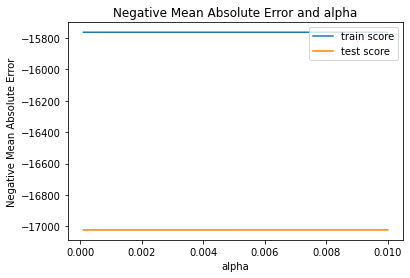

In [79]:
# plotting mean test and train scoes with alpha 

lasso_cv_results['param_alpha'] = lasso_cv_results['param_alpha'].astype('float64')

# plotting

plt.plot(lasso_cv_results['param_alpha'], lasso_cv_results['mean_train_score'])
plt.plot(lasso_cv_results['param_alpha'], lasso_cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')

plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()

In [101]:

# get the best estimator for lambda

lasso_model_cv.best_estimator_

Lasso(alpha=0.01)

In [102]:
# check the coefficient values with lambda = 0.0005

alpha = 0.01

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 
lasso.coef_

array([ 11412.93530709,   1445.04296834,   4219.22241321,   3921.12793762,
        19710.18648442,  25084.61237726,  -3422.09502819,  -4429.90034061,
         3037.71197041,   3352.99877454,   7145.71619987,   4043.96136747,
        -8375.32141356,  -4448.2800137 ,   3065.79566002,  -3135.82699157,
         6955.34111284,  -2341.59022667,   3207.83689097,   6026.10967769,
         5724.49853846,  -3654.24297256,   4010.96353212,  -2083.35954951,
         2683.51572438,   4584.02755386,   -440.1258849 ,   2727.45679687,
         1895.12668905,    824.68949053,   5926.94650324,    789.06248425,
         1243.12754004,   1191.4857581 ,   -685.6563755 ,    957.47469639,
         -410.88726994,    538.59628872,   3559.81500974,   4005.0167688 ,
          623.43146152,    278.58835703,   4776.16795521,   5383.99455233,
         6302.5021158 ,   5507.28467651,   4696.31263366,   2533.23390741,
         3874.78768255, -10298.30300169])

In [103]:

# Check the mean squared error

mean_squared_error(y_test, lasso.predict(X_test))

686866693.6560267

In [104]:

# Put the shortlisted Features and coefficienst in a dataframe

lasso_df = pd.DataFrame({'Features':X_train.columns, 'Coefficient':lasso.coef_.round(4)})
lasso_df = lasso_df[lasso_df['Coefficient'] != 0.00]
lasso_df.reset_index(drop=True, inplace=True)
lasso_df

,Features,Coefficient
0,BsmtFinSF1,11412.9353
1,BsmtFinSF2,1445.0430
2,BsmtUnfSF,4219.2224
3,TotalBsmtSF,3921.1279
4,1stFlrSF,19710.1865
5,2ndFlrSF,25084.6124
6,BedroomAbvGr,-3422.0950
7,KitchenAbvGr,-4429.9003
8,TotRmsAbvGrd,3037.7120
9,Fireplaces,3352.9988


In [84]:
# Put the Features and Coefficients in dictionary

lasso_coeff_dict = dict(pd.Series(lasso.coef_, index = X_train.columns))
lasso_coeff_dict

{'BsmtFinSF1': 11423.56726604667,
 'BsmtFinSF2': 1449.2226075464723,
 'BsmtUnfSF': 4230.254549609946,
 'TotalBsmtSF': 3912.3228426006212,
 '1stFlrSF': 19710.225307794666,
 '2ndFlrSF': 25084.664659564733,
 'BedroomAbvGr': -3422.13230365486,
 'KitchenAbvGr': -4429.891380881241,
 'TotRmsAbvGrd': 3037.702020900661,
 'Fireplaces': 3352.995309843828,
 'GarageArea': 7145.697076778043,
 'MiscVal': 4044.0404748020364,
 'DiffYearBuilt': -8375.341075229859,
 'DiffYearRemodAdd': -4448.2701116552,
 'Neighborhood_BrDale': 3065.8145089624727,
 'Neighborhood_CollgCr': -3135.8509543938317,
 'Neighborhood_Crawfor': 6955.34066502969,
 'Neighborhood_Gilbert': -2341.6206755143635,
 'Neighborhood_NPkVill': 3207.935307644563,
 'Neighborhood_NridgHt': 6026.120285078879,
 'Neighborhood_StoneBr': 5724.509110562801,
 'RoofStyle_Shed': -3676.9692431232875,
 'Exterior1st_BrkFace': 4011.0517086689993,
 'Exterior1st_CemntBd': -2083.6429913461743,
 'Exterior1st_HdBoard': 2683.512481217277,
 'Exterior1st_MetalSd': 458

###### RFE

In [105]:

# Do an RFE to minimise the features to 15

X_train_lasso = X_train[lasso_df.Features]

lm = LinearRegression()
lm.fit(X_train_lasso, y_train)

# running RFE

rfe = RFE(lm, 15)            
rfe = rfe.fit(X_train_lasso, y_train)

In [106]:
# Method to get the coefficient values

def find(x):
    return lasso_coeff_dict[x]

# Assign top 10 features to a temp dataframe for further display in the bar plot

temp2_df = pd.DataFrame(list(zip( X_train_lasso.columns, rfe.support_, rfe.ranking_)), columns=['Features', 'rfe_support', 'rfe_ranking'])
temp2_df = temp2_df.loc[temp2_df['rfe_support'] == True]
temp2_df.reset_index(drop=True, inplace=True)

temp2_df['Coefficient'] = temp2_df['Features'].apply(find)
temp2_df = temp2_df.sort_values(by=['Coefficient'], ascending=False)
temp2_df = temp2_df.head(10)
temp2_df

,Features,rfe_support,rfe_ranking,Coefficient
5,2ndFlrSF,True,1,25084.664660
4,1stFlrSF,True,1,19710.225308
0,BsmtFinSF1,True,1,11423.567266
7,GarageArea,True,1,7145.697077
9,Neighborhood_Crawfor,True,1,6955.340665
11,d_ExterQual,True,1,6302.492275
12,d_BsmtQual,True,1,5507.270675
10,SaleType_New,True,1,5384.000860
2,BsmtUnfSF,True,1,4230.254550
3,TotalBsmtSF,True,1,3912.322843


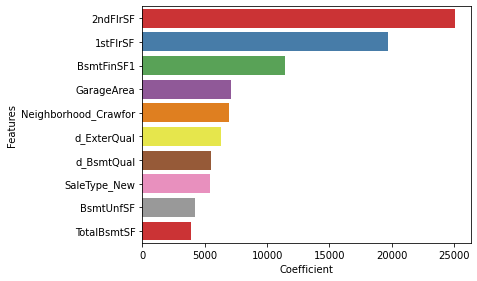

In [107]:
# bar plot to determine the variables that would affect pricing most using ridge regression

plt.figure(figsize=(20,20))
plt.subplot(4,3,1)
sns.barplot(y = 'Features', x='Coefficient', palette='Set1', data = temp2_df)
plt.show()

## Conclusion


#### The optimal lambda value in case of Ridge and Lasso is as below:

#### Ridge - 20
#### Lasso - 0.0005
#### The Mean Squared error in case of Ridge and Lasso are:

#### Ridge - 0.0148
#### Lasso - 0.0135
####  the Mean Squared Error of Lasso is slightly lower than that of Ridge

#### Based on selection of less features and MSE we should go with Laso in this use case.

#### The factors that generally affect the price are the Zoning classification, Living area square feet, overall material and finish of the house, Garage location, overall condition of the house and GarageArea 

# Part 2 

###### Question 1

###### What is the optimal value of alpha for ridge and lasso regression? What will be the changes in the model if you choose double the value of alpha for both ridge and lasso? What will be the most important predictor variables after the change is implemented?

In [88]:
# check the coefficient values with lambda = 20 * 2

alpha = 40
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
ridge.coef_


# Check the mean squared error

a = mean_squared_error(y_test, ridge.predict(X_test))

print("The mean square error is",a)

# Put the Features and coefficienst in a dataframe

ridge_df = pd.DataFrame({'Features':X_train.columns, 'Coefficient':ridge.coef_.round(4)})
ridge_df.reset_index(drop=True, inplace=True)
ridge_df


The mean square error is 625909137.1967372


,Features,Coefficient
0,BsmtFinSF1,7093.2648
1,BsmtFinSF2,-168.8773
2,BsmtUnfSF,-280.5344
3,TotalBsmtSF,8152.7099
4,1stFlrSF,15115.3332
5,2ndFlrSF,20009.7243
6,BedroomAbvGr,-2338.9476
7,KitchenAbvGr,-4637.4314
8,TotRmsAbvGrd,6003.8035
9,Fireplaces,4411.3758


In [89]:
# check the coefficient values with lambda = 0.0005

alpha = 0.0005 * 2

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 
lasso.coef_

array([ 11423.00768926,   1449.00262654,   4229.67391085,   3912.78626865,
        19710.22326446,  25084.66190786,  -3422.13034179,  -4429.89185245,
         3037.70254456,   3352.9954922 ,   7145.69808326,   4044.03631126,
        -8375.34004041,  -4448.27063282,   3065.81351691,  -3135.84969319,
         6955.3406886 ,  -2341.61907294,   3207.93012782,   6026.1197268 ,
         5724.50855414,  -3675.77312362,   4011.0470678 ,  -2083.62807335,
         2683.51265191,   4584.02397075,   -440.16130008,   2727.43087278,
         1895.12980811,    824.69196085,   5927.38486471,    789.39162413,
         1243.20906958,   1191.81618595,   -685.64030268,    957.75807849,
         -410.87082912,    538.73734766,   3560.25402821,   4005.31569873,
          623.57371033,    293.79201958,   4776.18704625,   5384.00052788,
         6302.49279312,   5507.27141171,   4696.32657356,   2533.24559994,
         3874.7861964 , -10298.34337818])

In [90]:
# Check the mean squared error

mean_squared_error(y_test, lasso.predict(X_test))

687223582.983104

In [91]:
# Put the shortlisted Features and coefficienst in a dataframe

lasso_df = pd.DataFrame({'Features':X_train.columns, 'Coefficient':lasso.coef_.round(4)})
lasso_df = lasso_df[lasso_df['Coefficient'] != 0.00]
lasso_df.reset_index(drop=True, inplace=True)
lasso_df

,Features,Coefficient
0,BsmtFinSF1,11423.0077
1,BsmtFinSF2,1449.0026
2,BsmtUnfSF,4229.6739
3,TotalBsmtSF,3912.7863
4,1stFlrSF,19710.2233
5,2ndFlrSF,25084.6619
6,BedroomAbvGr,-3422.1303
7,KitchenAbvGr,-4429.8919
8,TotRmsAbvGrd,3037.7025
9,Fireplaces,3352.9955


###### Question 2

###### You have determined the optimal value of lambda for ridge and lasso regression during the assignment. Now, which one will you choose to apply and why?

### Question 3

### After building the model, you realised that the five most important predictor variables in the lasso model are not available in the incoming data. You will now have to create another model excluding the five most important predictor variables. Which are the five most important predictor variables now?

###### Question 4

###### How can you make sure that a model is robust and generalisable? What are the implications of the same for the accuracy of the model and why?